In [ ]:
from google.colab import files

# This command will open a file upload dialog in your browser
uploaded = files.upload()

# The 'uploaded' variable is a dictionary containing the file names and their contents.
# We can print the names of the files that were uploaded.
for filename in uploaded.keys():
  print(f'✅ User uploaded file "{filename}" with length {len(uploaded[filename])} bytes')

Saving Ambience Church Bells 01.wav to Ambience Church Bells 01.wav
✅ User uploaded file "Ambience Church Bells 01.wav" with length 11545472 bytes


Error: 'Ambience Church Bells 01.wav' not found. Please add a speech file to the directory.
Using a generated sine wave as a placeholder.


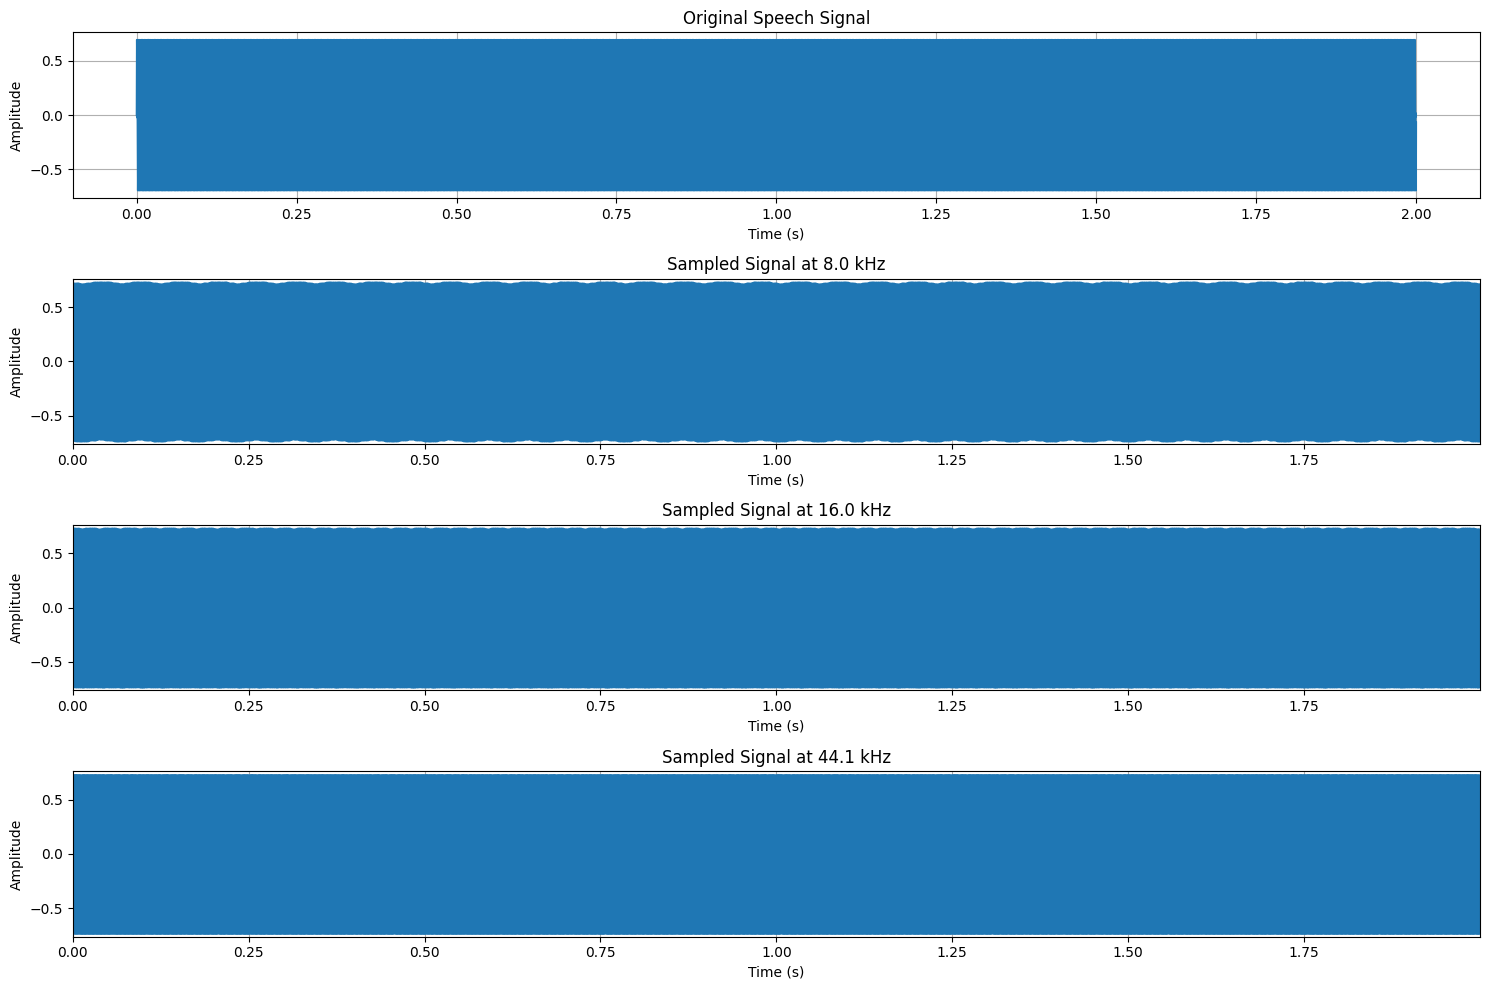

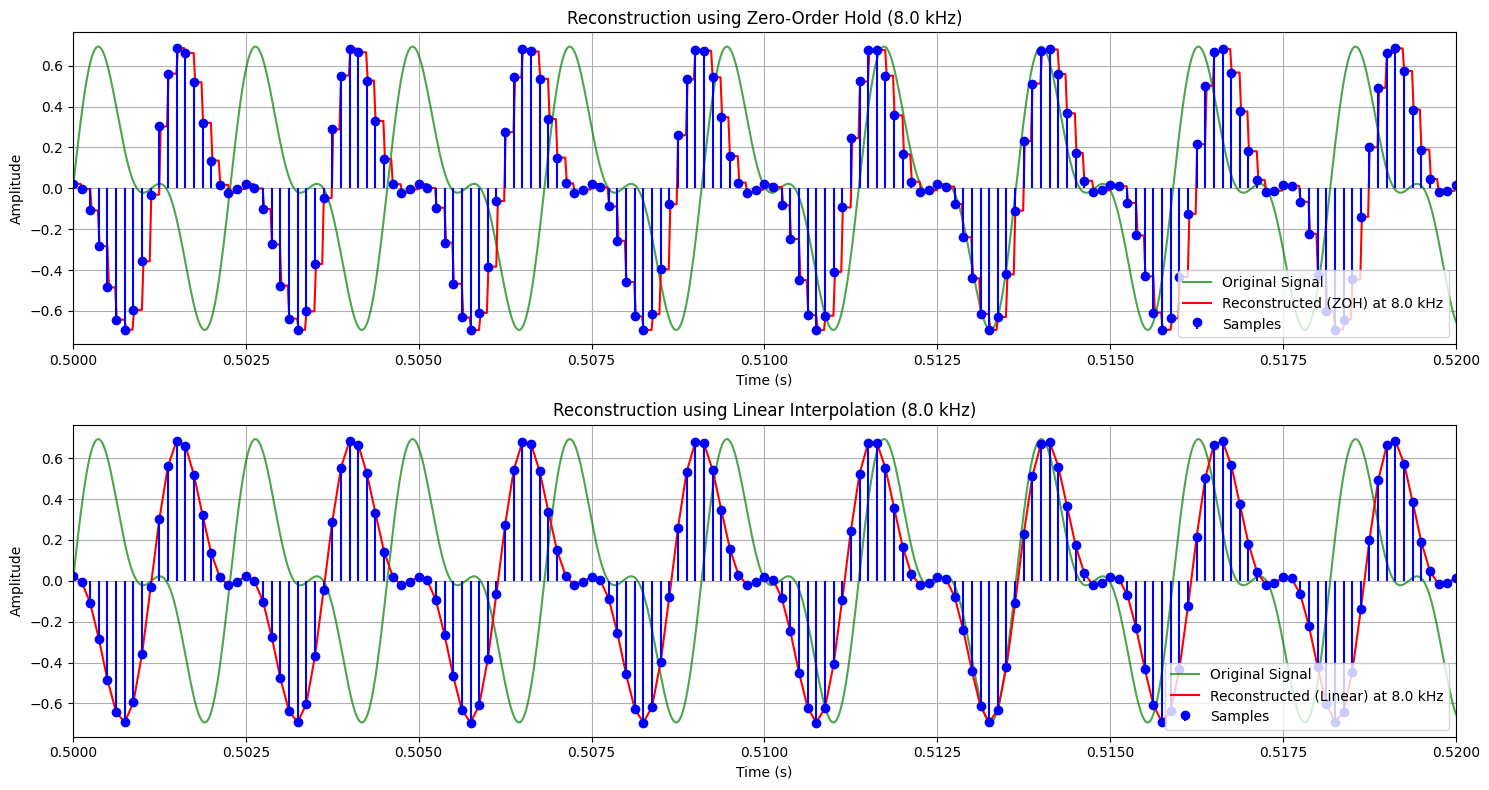

Mean Squared Error (MSE) Results:
          Zero-Order Hold  Linear Interpolation
8.0 kHz          0.340614          3.356819e-01
16.0 kHz         0.339945          3.391156e-01
44.1 kHz         0.000000          4.375037e-37


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.interpolate import interp1d

# --- Helper function to calculate MSE ---
def calculate_mse(original, reconstructed):
    """Calculates the Mean Squared Error between two signals."""
    # Ensure signals are the same length for comparison
    min_len = min(len(original), len(reconstructed))
    original = original[:min_len]
    reconstructed = reconstructed[:min_len]
    return np.mean((original - reconstructed) ** 2)

# --- Load the speech signal ---
# Note: You need a .wav file named 'Ambience Church Bells 01.wav' in the same directory.
# You can record your own or download one.
try:
    filename='Ambience Church Bells 01.wav'
    original_fs, original_signal = wavfile.read(filename)
    # Normalize the signal to be between -1 and 1
    if original_signal.dtype == 'int16':
        original_signal = original_signal / 32768.0
except FileNotFoundError:
    print("Error: 'Ambience Church Bells 01.wav' not found. Please add a speech file to the directory.")
    # Create a dummy signal for demonstration if file is not found
    original_fs = 44100
    t_dummy = np.linspace(0, 2, 2 * original_fs, endpoint=False)
    original_signal = 0.5 * np.sin(2 * np.pi * 440 * t_dummy) + 0.3 * np.sin(2 * np.pi * 880 * t_dummy)
    print("Using a generated sine wave as a placeholder.")

# Create the time axis for the original signal
time_original = np.arange(len(original_signal)) / original_fs

# (a) Plot the time domain representation of the original speech signal
plt.figure(figsize=(15, 10))
plt.subplot(4, 1, 1)
plt.plot(time_original, original_signal)
plt.title('Original Speech Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)

# (b) Sample the speech signal at different sampling rates
sampling_rates = [8000, 16000, 44100]
sampled_signals = {}
reconstructed_signals = {}
mse_results = {"Zero-Order Hold": {}, "Linear Interpolation": {}}

plot_index = 2
for fs in sampling_rates:
    # Calculate the number of samples for the new rate
    num_samples = int(len(original_signal) * fs / original_fs)

    # Downsample by taking every Nth sample (simple method)
    step = int(original_fs / fs)
    sampled_signal = original_signal[::step]
    time_sampled = np.arange(len(sampled_signal)) / fs

    sampled_signals[fs] = (time_sampled, sampled_signal)

    # (c) Plot sampled speech signal
    plt.subplot(4, 1, plot_index)
    plt.stem(time_sampled, sampled_signal, basefmt=" ")
    plt.title(f'Sampled Signal at {fs/1000} kHz')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.xlim(time_original[0], time_original[-1]) # Use original time limits for comparison
    plt.grid(True)
    plot_index += 1

    # (d) Reconstruct the signal
    # (i) Zero-Order Hold
    f_zoh = interp1d(time_sampled, sampled_signal, kind='zero', bounds_error=False, fill_value="extrapolate")
    reconstructed_zoh = f_zoh(time_original)

    # (ii) Linear Interpolation
    f_linear = interp1d(time_sampled, sampled_signal, kind='linear', bounds_error=False, fill_value="extrapolate")
    reconstructed_linear = f_linear(time_original)

    reconstructed_signals[fs] = {
        "zoh": reconstructed_zoh,
        "linear": reconstructed_linear
    }

    # (e) Calculate the Mean Squared Error (MSE)
    mse_results["Zero-Order Hold"][f'{fs/1000} kHz'] = calculate_mse(original_signal, reconstructed_zoh)
    mse_results["Linear Interpolation"][f'{fs/1000} kHz'] = calculate_mse(original_signal, reconstructed_linear)

plt.tight_layout()
plt.show()


# --- Plotting the reconstructed signals for one case (e.g., 8kHz) for visualization ---
fs_to_plot = 8000
plt.figure(figsize=(15, 8))

# Original vs. Zero-Order Hold
plt.subplot(2, 1, 1)
plt.plot(time_original, original_signal, 'g-', label='Original Signal', alpha=0.7)
plt.plot(time_original, reconstructed_signals[fs_to_plot]['zoh'], 'r-', label=f'Reconstructed (ZOH) at {fs_to_plot/1000} kHz')
plt.stem(sampled_signals[fs_to_plot][0], sampled_signals[fs_to_plot][1], 'b', markerfmt='bo', basefmt=" ", label='Samples')
plt.title(f'Reconstruction using Zero-Order Hold ({fs_to_plot/1000} kHz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.xlim(0.5, 0.52) # Zoom in to see the detail

# Original vs. Linear Interpolation
plt.subplot(2, 1, 2)
plt.plot(time_original, original_signal, 'g-', label='Original Signal', alpha=0.7)
plt.plot(time_original, reconstructed_signals[fs_to_plot]['linear'], 'r-', label=f'Reconstructed (Linear) at {fs_to_plot/1000} kHz')
plt.stem(sampled_signals[fs_to_plot][0], sampled_signals[fs_to_plot][1], 'b', markerfmt='bo', basefmt=" ", label='Samples')
plt.title(f'Reconstruction using Linear Interpolation ({fs_to_plot/1000} kHz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.xlim(0.5, 0.52) # Zoom in to see the detail

plt.tight_layout()
plt.show()


# --- Print MSE Results ---
import pandas as pd
df_mse = pd.DataFrame(mse_results)
print("Mean Squared Error (MSE) Results:")
print(df_mse)

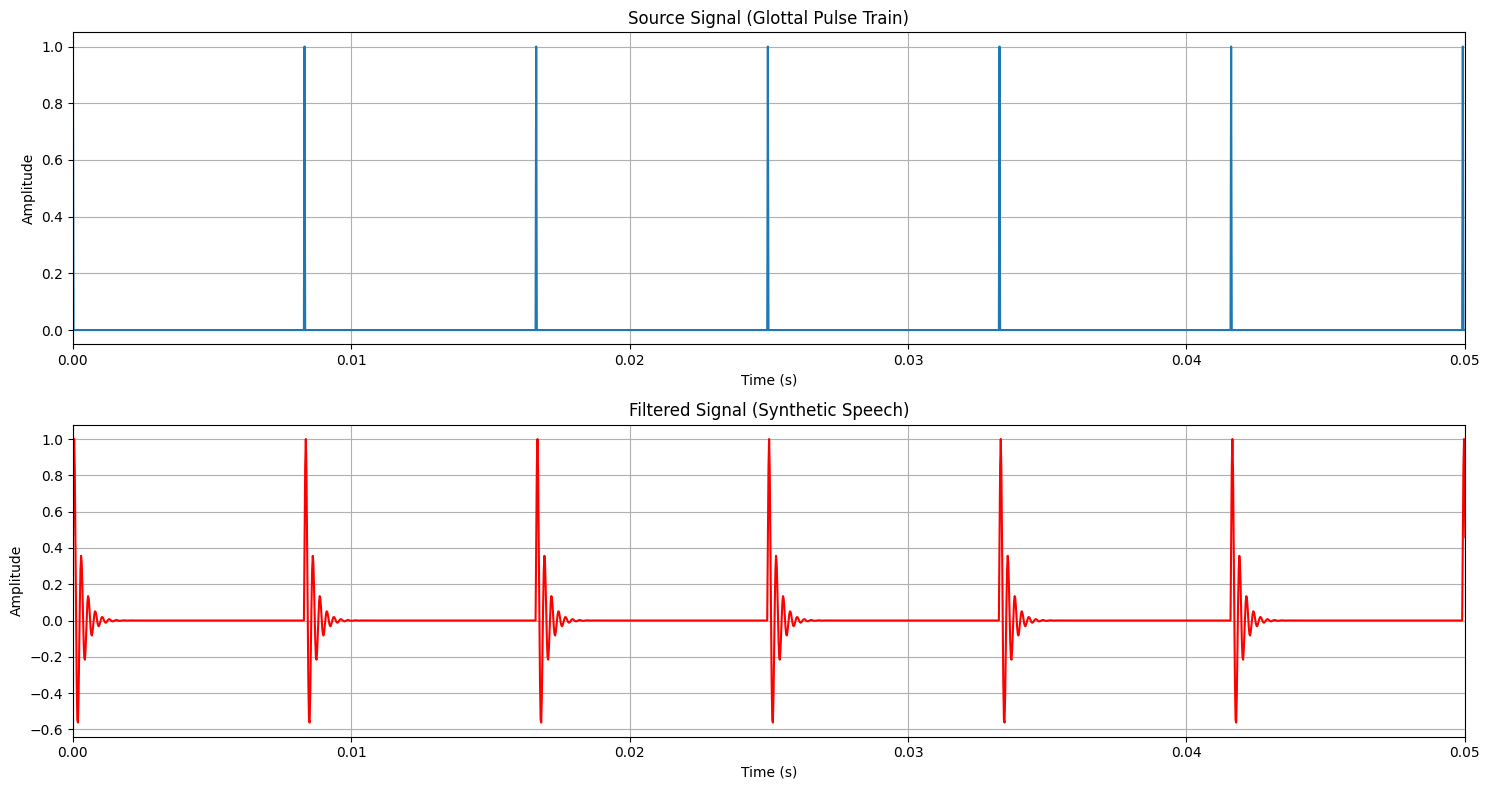


Mean Squared Error (MSE) for Synthetic Signal:
          Linear Interpolation
8.0 kHz           1.706151e-02
16.0 kHz          2.129741e-02
44.1 kHz          6.092525e-27


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter

# --- Helper function from Part 1 ---
def calculate_mse(original, reconstructed):
    min_len = min(len(original), len(reconstructed))
    return np.mean((original[:min_len] - reconstructed[:min_len]) ** 2)

# --- (a) Generate a synthetic speech signal using the source-filter model ---
fs_synth = 44100  # Use a high sampling rate for the "original" synthetic signal
duration = 1.0     # 1 second
t = np.arange(0, duration, 1/fs_synth)

# (i) Create a source signal (glottal pulse train for a voiced sound like 'ahh')
f0 = 120  # Fundamental frequency (Hz)
period_samples = int(fs_synth / f0)
source_signal = np.zeros(len(t))
source_signal[::period_samples] = 1.0

# (ii) Apply a filter that models the vocal tract (all-pole filter)
# These coefficients define formants (resonances) that shape the sound.
# For a vowel /a/ (like in "father")
# Formants at ~700 Hz, ~1220 Hz, ~2600 Hz
# We define the denominator 'a' of the transfer function H(z) = 1/A(z)
# For an all-pole filter, the numerator 'b' is just [1.0]
b = [1.0]
a = [1, -2.14, 2.05, -1.07, 0.43, -0.1] # Example coefficients for a vowel sound

# Generate the synthetic speech by filtering the source
synthetic_speech = lfilter(b, a, source_signal)
# Normalize the output
synthetic_speech = synthetic_speech / np.max(np.abs(synthetic_speech))

# (b) Plot the generated speech signal and analyze the effect of the filter
plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.plot(t, source_signal)
plt.title('Source Signal (Glottal Pulse Train)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlim(0, 0.05) # Zoom in to see the pulses
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(t, synthetic_speech, 'r-')
plt.title('Filtered Signal (Synthetic Speech)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlim(0, 0.05) # Zoom in to the same region
plt.grid(True)

plt.tight_layout()
plt.show()

# --- (c, d, e) Sample, Reconstruct, and Compute MSE ---
sampling_rates_synth = [8000, 16000, 44100]
mse_results_synth = {"Linear Interpolation": {}}

for fs in sampling_rates_synth:
    # Downsample
    step = int(fs_synth / fs)
    sampled_synth = synthetic_speech[::step]
    time_sampled_synth = np.arange(len(sampled_synth)) / fs

    # Reconstruct using Linear Interpolation
    f_linear_synth = interp1d(time_sampled_synth, sampled_synth, kind='linear', bounds_error=False, fill_value="extrapolate")
    reconstructed_synth = f_linear_synth(t) # Reconstruct on original high-res time axis

    # Compute MSE
    mse_results_synth["Linear Interpolation"][f'{fs/1000} kHz'] = calculate_mse(synthetic_speech, reconstructed_synth)

# --- Print MSE Results for Synthetic Signal ---
df_mse_synth = pd.DataFrame(mse_results_synth)
print("\nMean Squared Error (MSE) for Synthetic Signal:")
print(df_mse_synth)

In [ ]:
from scipy.io import wavfile
import os

# The name of the file you want to test
filename = '/Ambience Church Bells 01.wav'

print(f"Attempting to read the file: '{filename}'...")
print(f"Current working directory: {os.getcwd()}")
print("-" * 30)

try:
    # Attempt to read the .wav file
    sampling_rate, data = wavfile.read(filename)

    # If the above line works without error, the file was found and read.
    print(f"✅ Success! File '{filename}' was loaded correctly.")
    print(f"   - Sampling Rate: {sampling_rate} Hz")
    print(f"   - Number of Samples: {len(data)}")
    print(f"   - Duration: {len(data) / sampling_rate:.2f} seconds")

except FileNotFoundError:
    # This block runs if the file does not exist in the directory.
    print(f"❌ Error: The file '{filename}' was not found.")
    print("   - **Solution**: Make sure your 'speech.wav' file is in the same folder as this script.")

except Exception as e:
    # This block catches other potential errors (e.g., file is not a valid .wav file).
    print(f"❌ An unexpected error occurred: {e}")
    print(f"   - **Solution**: Ensure the file is a valid, uncorrupted WAV file.")

Attempting to read the file: '/Ambience Church Bells 01.wav'...
Current working directory: /content
------------------------------
✅ Success! File '/Ambience Church Bells 01.wav' was loaded correctly.
   - Sampling Rate: 48000 Hz
   - Number of Samples: 2882880
   - Duration: 60.06 seconds


/tmp/ipython-input-2142195473.py:13: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampling_rate, data = wavfile.read(filename)
